# ARIMA Time Series Forecasting

ARIMA model assumption - stationary: the time series has its statistical properties remain constant across time

ARIMA models combine three distinct components:
1. Autoregression, represented as AR
2. Differencing, represented as I
3. Moving average, represented as MA

Three components/parameters: AR + I + MA (p, d, q)
1. p (Autoregression Order): The number of lag observations included in the model.
2. d (Differencing Order): The number of times the data have had past values subtracted (to make the data stationary).
3. q (Moving Average Order): The size of the moving average window.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step 1: Load and Preprocess the Dataset

In [98]:
Canadian_data=pd.read_csv('Canadian Sales.csv')

Canadian_data.reset_index(inplace=True)
Canadian_data = Canadian_data[['REF_DATE', 'VALUE']]

Canadian_data['REF_DATE'] = pd.to_datetime(Canadian_data['REF_DATE'])

print(Canadian_data.dtypes)
Canadian_data.head()

REF_DATE    datetime64[ns]
VALUE              float64
dtype: object


,REF_DATE,VALUE
0,1946-10-01,11462.0
1,1946-11-01,13497.0
2,1946-12-01,12689.0
3,1947-01-01,13977.0
4,1947-02-01,15806.0


In [99]:
# display last 12 rows
Canadian_data.tail(12)

,REF_DATE,VALUE
2100,2023-03-01,8483490.0
2101,2023-04-01,8252891.0
2102,2023-05-01,9648708.0
2103,2023-06-01,9352513.0
2104,2023-07-01,8190694.0
2105,2023-08-01,8926326.0
2106,2023-09-01,9154748.0
2107,2023-10-01,8400811.0
2108,2023-11-01,8071438.0
2109,2023-12-01,7455783.0


In [100]:
# filter data for 2019
Canadian_data = Canadian_data[(Canadian_data['REF_DATE'].dt.year <= 2019) & (Canadian_data['REF_DATE'].dt.year >= 2009)]


In [101]:
# Check for missing values
print(Canadian_data.isnull().sum())

REF_DATE    0
VALUE       0
dtype: int64


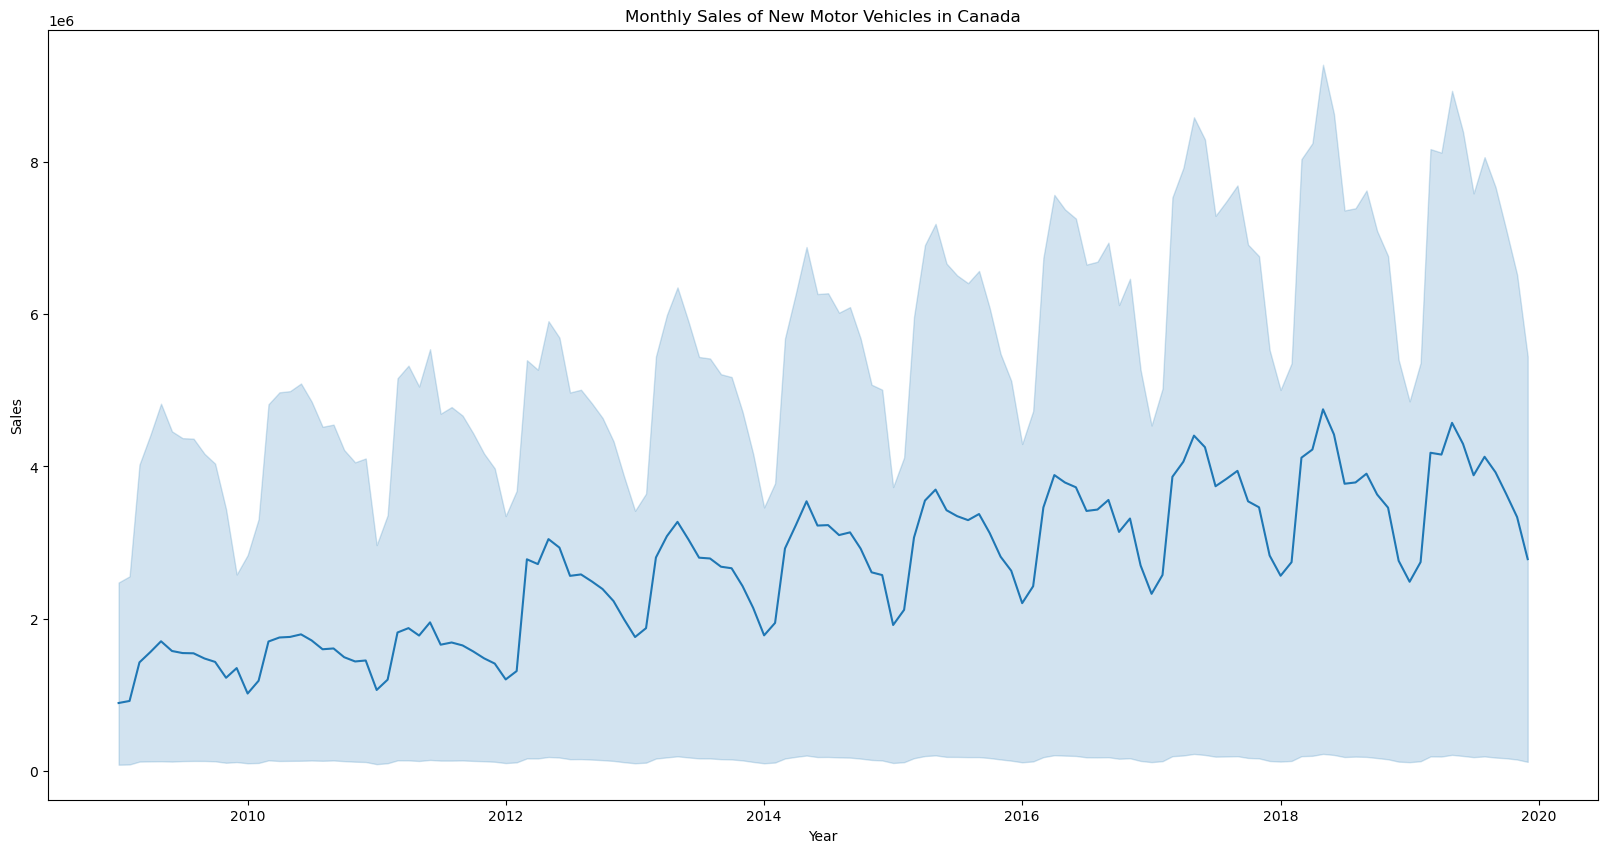

In [102]:
# Adjust figure size
plt.figure(figsize=(20, 10))

# Plot the lineplot
sns.lineplot(data=Canadian_data, x='REF_DATE', y='VALUE')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Monthly Sales of New Motor Vehicles in Canada')
plt.show()

## Step 2: Check for Stationarity

In [103]:
# Function to perform the Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Applying the Dickey-Fuller test on the 'VALUE' column
test_stationarity(Canadian_data['VALUE'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.027316
p-value                          0.956214
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


If the p-value is less than 0.05 and the test statistic is less than the critical values, we can conclude the series is stationary.

But it is not, we'll consider applying transformations to make it stationary.

## Step 3: Data Transformation

In [104]:
# First differencing
# Canadian_data['VALUE_diff'] = Canadian_data['VALUE'].diff()

Canadian_data['Sales_First_Difference'] = Canadian_data['VALUE'] - Canadian_data['VALUE'].shift(1)
Canadian_data['Seasonal_First_Difference']=Canadian_data['VALUE']-Canadian_data['VALUE'].shift(12)
Canadian_data.dropna().head()

,REF_DATE,VALUE,Sales_First_Difference,Seasonal_First_Difference
759,2010-01-01,83512.0,-30101.0,4695.0
760,2010-02-01,101788.0,18276.0,19749.0
761,2010-03-01,148052.0,46264.0,18221.0
762,2010-04-01,152187.0,4135.0,6161.0
763,2010-05-01,157082.0,4895.0,1057.0


In [105]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")


# Again testing if data is stationary
adfuller_test(Canadian_data['Seasonal_First_Difference'].dropna())

ADF Test Statistic : -3.146257295515298
p-value : 0.02331399853049962
#Lags Used : 14
Number of Observations : 275
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Axes: >

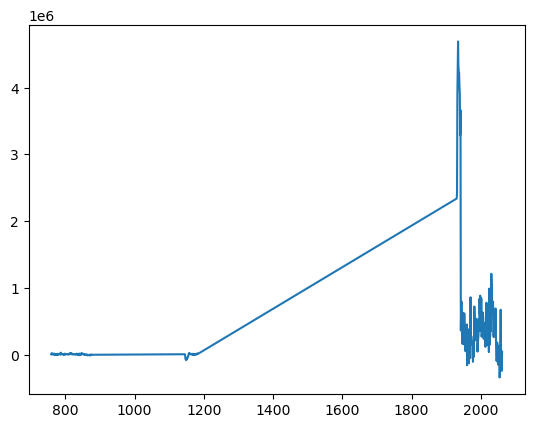

In [106]:
Canadian_data['Seasonal_First_Difference'].plot()

## Step 4: Identify and Remove Outliers

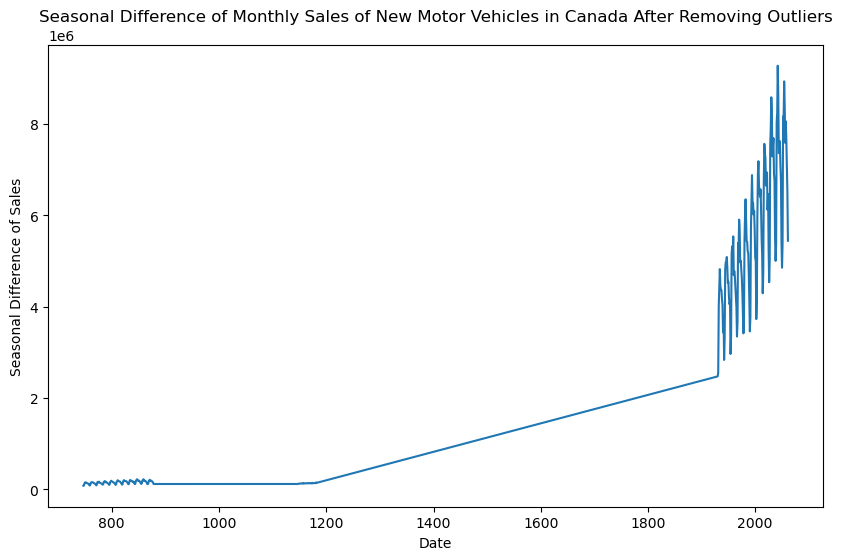

In [107]:
# Calculate IQR
Q1 = Canadian_data['VALUE'].quantile(0.25)
Q3 = Canadian_data['VALUE'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
filtered_data = Canadian_data[(Canadian_data['VALUE'] >= lower_bound) & (Canadian_data['VALUE'] <= upper_bound)]

# Plot to see data after removing outliers
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['VALUE'])
plt.title('Seasonal Difference of Monthly Sales of New Motor Vehicles in Canada After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('Seasonal Difference of Sales')
plt.show()

## Step 5: Split the Data into Training and Test Sets

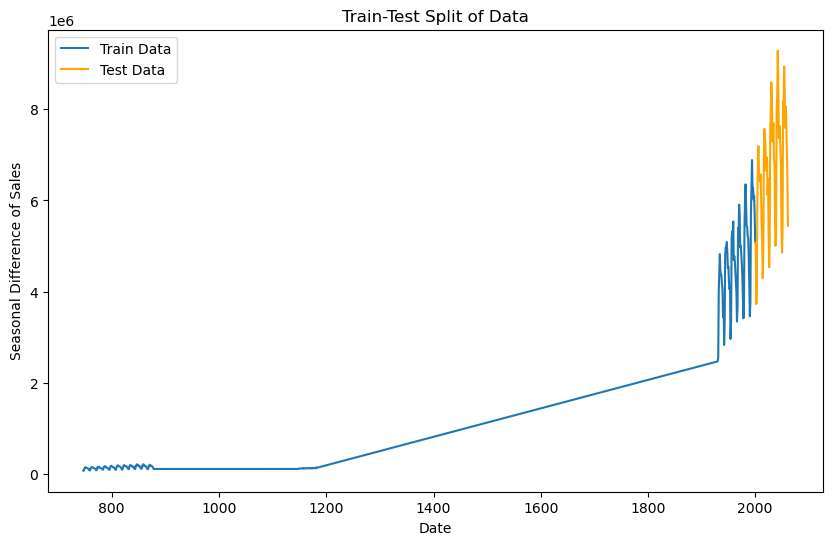

In [108]:
# Calculate the split point
split_point = int(len(filtered_data) * 0.8)

# Split into training and test sets
train_data = filtered_data[:split_point]
test_data = filtered_data[split_point-1:]

# Plot both to visually inspect the split
plt.figure(figsize=(10, 6))
plt.plot(train_data['VALUE'], label='Train Data')
plt.plot(test_data['VALUE'], label='Test Data', color='orange')
plt.title('Train-Test Split of Data')
plt.xlabel('Date')
plt.ylabel('Seasonal Difference of Sales')
plt.legend()
plt.show()

## Step 6: Model Identification

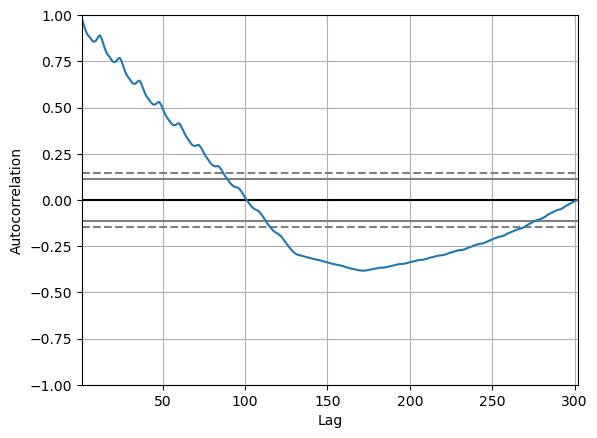

In [109]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(Canadian_data['VALUE'])
plt.show()

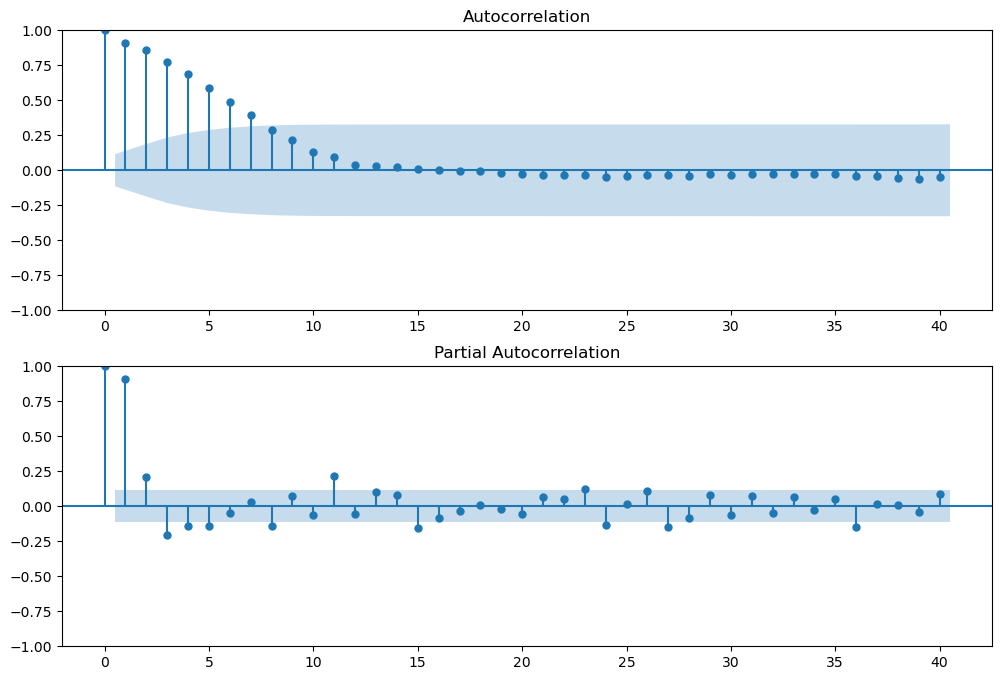

In [110]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Canadian_data['Seasonal_First_Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Canadian_data['Seasonal_First_Difference'].dropna(),lags=40,ax=ax2)

## Step 7: Model Fitting

In [111]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(Canadian_data['VALUE'], order=(12, 2, 1))
model_fit = model.fit()
model_fit.summary()

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                  302
Model:                ARIMA(12, 2, 1)   Log Likelihood               -4205.646
Date:                Tue, 23 Apr 2024   AIC                           8439.293
Time:                        12:21:02   BIC                           8491.145
Sample:                             0   HQIC                          8460.044
                                - 302                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1173      0.057     -2.070      0.038      -0.228      -0.006
ar.L2          0.0715      0.048      1.476      0.140      -0.023       0.166
ar.L3         -0.1039      0.057     -1.818      0.069      -0.216       0.008
ar.L4         -0.0875      0.050     -1.747      0.081      -0.186       0.011
ar.L5         -0.1310      0.063     -2.068      0.039      -0.255      -0.007
ar.L6          0.0009      0.054      0.016      0.988      -0.106       0.107
ar.L7         -0.0532      0.056     -0.948      0.343      -0.163       0.057
ar.L8         -0.1928      0.061     -3.136      0.002      -0.313      -0.072
ar.L9         -0.0554      0.059     -0.938      0.348      -0.171       0.060
ar.L10        -0.1608      0.061     -2.643      0.008      -0.280      -0.042
ar.L11         0.1134      0.059      1.908      0.056      -0.003       0.230
ar.L12         0.7175      0.054     13.220      0.000       0.611       0.824
ma.L1         -0.9739      0.037    -26.163      0.000      -1.047      -0.901
sigma2      8.778e+10   1.48e-12   5.92e+22      0.000    8.78e+10    8.78e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.22   Jarque-Bera (JB):             11468.08
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):             597.90   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+38. Standard errors may be unstable.
"""

## Step 8: Model Evaluation and Forecasting

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


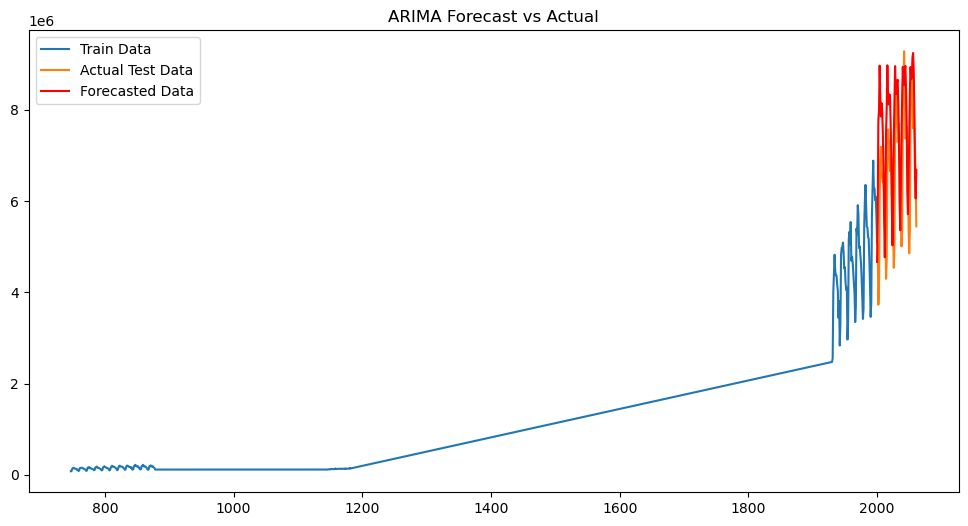

MSE: 2564003178938.5757, MAE: 1249417.8104497425, RMSE: 1601250.5047426452


In [112]:
# Make forecast
forecast = model_fit.forecast(steps=len(test_data))

# Visual comparison
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['VALUE'], label='Train Data')
plt.plot(test_data.index, test_data['VALUE'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

# Calculate performance metrics
mse = mean_squared_error(test_data['VALUE'], forecast)
mae = mean_absolute_error(test_data['VALUE'], forecast)
rmse = np.sqrt(mse)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

In [113]:
# Canadian_data['forecast']=model_fit.predict(start=0,end=120,dynamic=True)
# Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

In [114]:
Canadian_data.shape

(302, 4)

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52870D+01    |proj g|=  2.75980D+00

At iterate    5    f=  1.39811D+01    |proj g|=  1.53429D-01

At iterate   10    f=  1.39533D+01    |proj g|=  3.97275D-02

At iterate   15    f=  1.39359D+01    |proj g|=  1.45517D-01

At iterate   20    f=  1.39319D+01    |proj g|=  5.62827D-03

At iterate   25    f=  1.39317D+01    |proj g|=  3.07731D-02

At iterate   30    f=  1.39315D+01    |proj g|=  2.46516D-02

At iterate   35    f=  1.39303D+01    |proj g|=  6.35668D-02

At iterate   40    f=  1.39288D+01    |proj g|=  1.51853D-02

At iterate   45    f=  1.39274D+01    |proj g|=  2.59304D-02

At iterate   50    f=  1.39260D+01    |proj g|=  2.73087D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

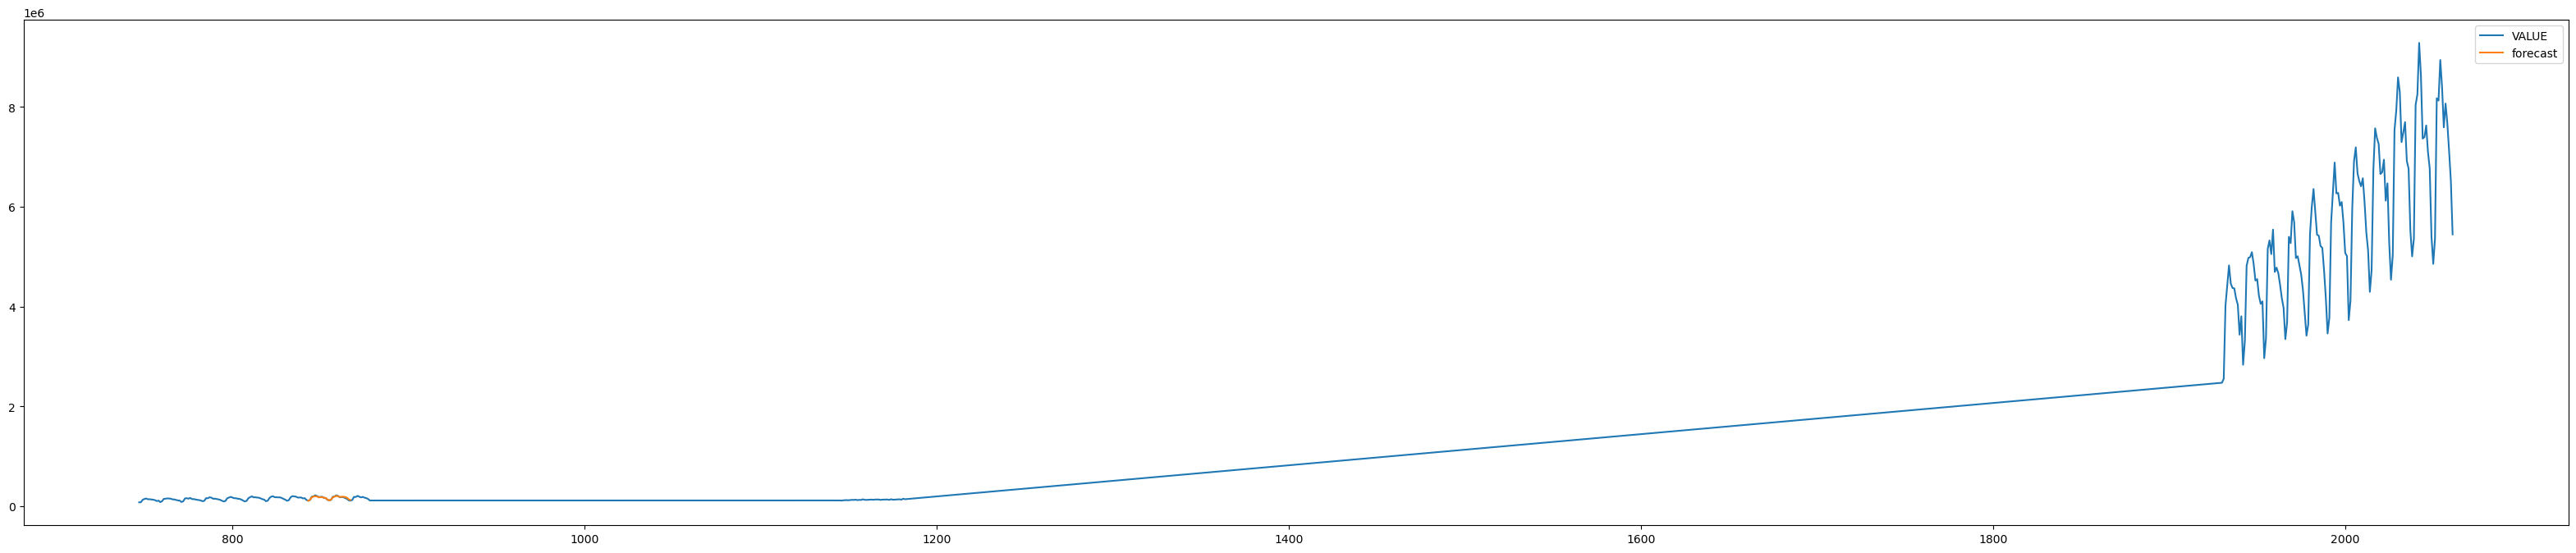

In [115]:
import statsmodels.api as sm
# model=sm.tsa.statespace.SARIMAX(Canadian_data['VALUE'],order=(12, 2, 1),seasonal_order=(12,2,1,12))
model=sm.tsa.statespace.SARIMAX(Canadian_data['VALUE'],order=(12, 2, 1))

results=model.fit()
Canadian_data['forecast']=results.predict(start=96,end=120,dynamic=True)
Canadian_data[['VALUE','forecast']].plot(figsize=(40,8))

In [116]:
Canadian_data.tail(12)

,REF_DATE,VALUE,Sales_First_Difference,Seasonal_First_Difference,forecast
2050,2019-01-01,4856206.0,-544030.0,-150038.0,NaN
2051,2019-02-01,5360981.0,504775.0,6293.0,NaN
2052,2019-03-01,8172306.0,2811325.0,132223.0,NaN
2053,2019-04-01,8126000.0,-46306.0,-123951.0,NaN
2054,2019-05-01,8938556.0,812556.0,-343147.0,NaN
2055,2019-06-01,8400102.0,-538454.0,-233931.0,NaN
2056,2019-07-01,7590172.0,-809930.0,224285.0,NaN
2057,2019-08-01,8066498.0,476326.0,672000.0,NaN
2058,2019-09-01,7673545.0,-392953.0,45279.0,NaN
2059,2019-10-01,7116489.0,-557056.0,19445.0,NaN


/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

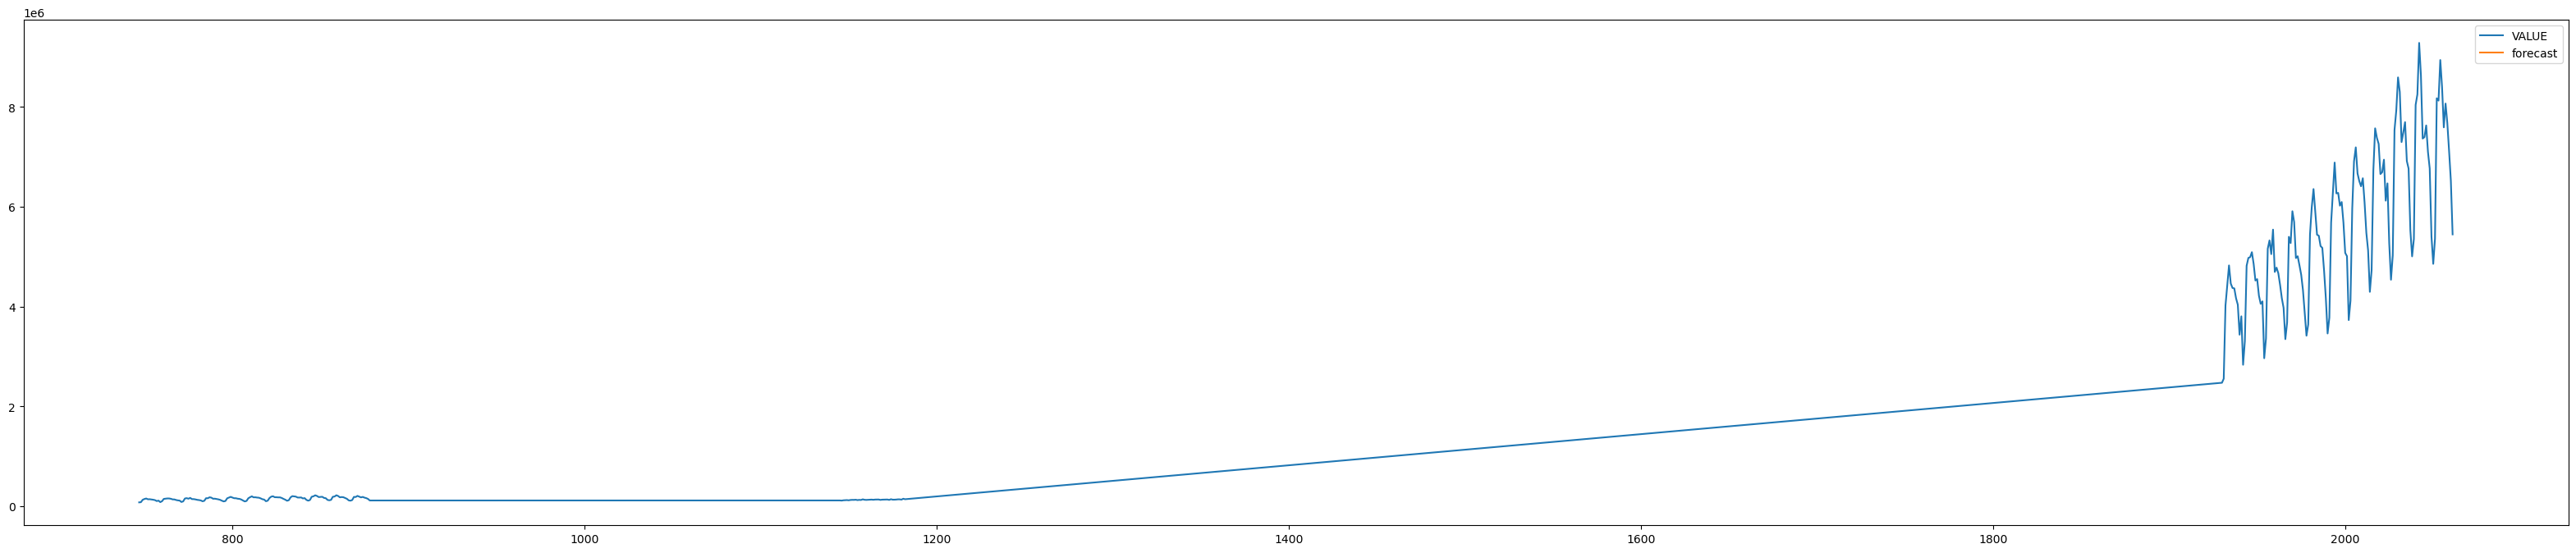

In [117]:
from pandas.tseries.offsets import DateOffset

# Convert the last date in the index to a Timestamp object
last_date = Canadian_data['REF_DATE'].index[-1]
#last_date = pd.to_datetime(last_date)

# Now you should be able to add DateOffset to the last date in the index
future_dates = [last_date + x for x in range(0, 24)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=Canadian_data.columns)

# Concatenate the original dataframe with the future dates dataframe
future_df = pd.concat([Canadian_data, future_datest_df])

# Assuming 'results' is your fitted model and it's already defined
future_df['forecast'] = results.predict(start=len(Canadian_data), end=len(Canadian_data)+24, dynamic=True)
future_df[['VALUE', 'forecast']].plot(figsize=(40, 8))


In [118]:
future_df[['VALUE', 'forecast']].tail(30)

,VALUE,forecast
2055,8400102.0,NaN
2056,7590172.0,NaN
2057,8066498.0,NaN
2058,7673545.0,NaN
2059,7116489.0,NaN
2060,6522466.0,NaN
2061,5446466.0,NaN
2062,NaN,NaN
2063,NaN,NaN
2064,NaN,NaN
